In [1]:
from devito import *
from examples.seismic import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Parameter Configuration 
# -----------------------

nx   = 500          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction
# Note: regular 2D grid, dz = dx
dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 580.         # wave velocity in medium (m/s)
isx  = 250          # source location in grid in x-direction
isz  = isx          # source location in grid in z-direction
irx  = 330          # receiver location in grid in x-direction
irz  = isz          # receiver location in grid in z-direction
nt   = 502          # maximum number of time steps
dt   = 0.0010       # time step

time = np.linspace(0 * dt, nt * dt, nt)

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value
print("Epsilon: %s" % eps)

Epsilon: 0.58


Source frequency = 40.0 Hz


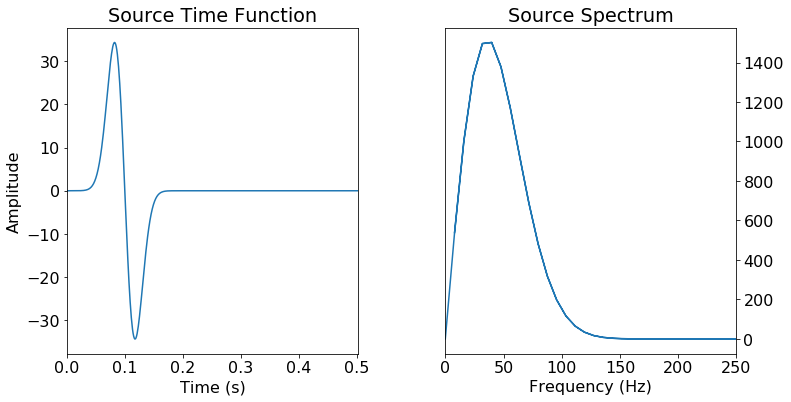

In [3]:
# Plot Source Time Function 
# -------------------------

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

print('Source frequency =', f0, 'Hz')

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

# Plot Position Configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(12, 6))
gs1  = gridspec.GridSpec(1,2,width_ratios=[1,1],height_ratios=[1],hspace=0.3, wspace=0.3)
ax = plt.subplot2grid((2, 1), (0, 0))

# Plot Source Time Function
# -------------------------
ax1  = plt.subplot(gs1[0])
#ax1  = plt.subplot(1, 2, 1)
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot Source Spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
#ax2  = plt.subplot(2, 2, 1)
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

# Strore a copy and avoid name clashes
_source = src

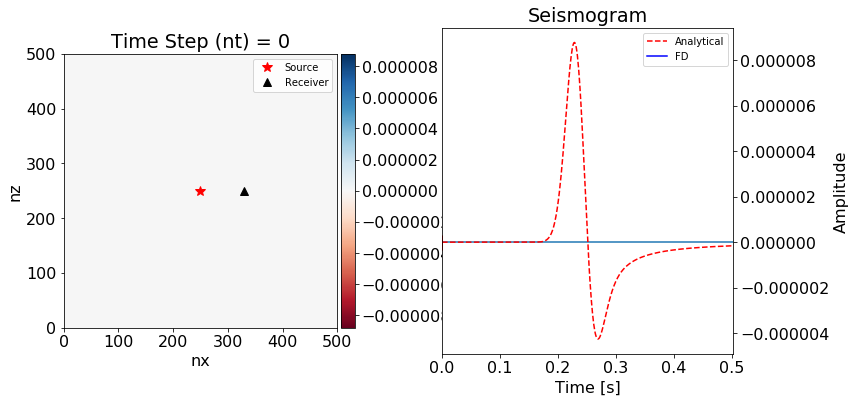

In [4]:
# Plot Snapshot & Seismogram (PLEASE RERUN THIS CODE AGAIN AFTER SIMULATION!) 
# ---------------------------------------------------------------------------

# Initialize Empty Pressure
# -------------------------
p    = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

# Initialize Velocity Model (assume homogeneous model)
# ----------------------------------------------------
c    = np.zeros((nz, nx))
c    = c + c0             # initialize wave velocity in model

# Initialize Grid
x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

# Initialize Empty Seismogram
# ---------------------------
seis = np.zeros(nt)

# Analytical Solution 
# -------------------
G    = time * 0.
r    = np.sqrt((x[isx] - x[irx]) ** 2 + (z[isz] - z[irz]) ** 2)

for it in range(nt): # Calculate Green's function
    if ((time[it] - np.abs(x[irx] - x[isx]) / c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2)) \
        * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from maximum amplitude of analytical solution

# Plot Position Configuration
# ---------------------------
plt.ion()
fig2 = plt.figure(figsize=(12, 6))
gs2  = gridspec.GridSpec(1,2,width_ratios=[1,1],height_ratios=[1],hspace=0.3, wspace=0.3)

# Plot 2D Wave Propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isx, isz, 'r*', markersize=11) # plot position of the source in model
leg2,= ax3.plot(irx, irz, 'k^', markersize=8)  # plot position of the receiver in model
im3  = ax3.imshow(p, vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div  = make_axes_locatable(ax3)
cax  = div.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im3, cax=cax) # plot colorbar
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlim(0, nx)
ax3.set_ylim(0, nz)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot Seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
up41,= ax4.plot(time, seis) # update seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Amplitude')
leg3,= ax4.plot(0,0,'r--',markersize=1)
leg4,= ax4.plot(0,0,'b-',markersize=1)
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")

plt.plot(time,Gc,'r--')
plt.show()

## Now in Devito....

In [5]:
# Speed of sound in km/s
vp = np.zeros((nx+1, nz+1), dtype=np.float32) + 0.580  # + 580. 
model = Model(origin=(0., 0.), spacing=(dx, dz), shape=(nx+1, nz+1), vp=vp, nbpml=0)

# plot_velocity(model)
# model.grid.spacing

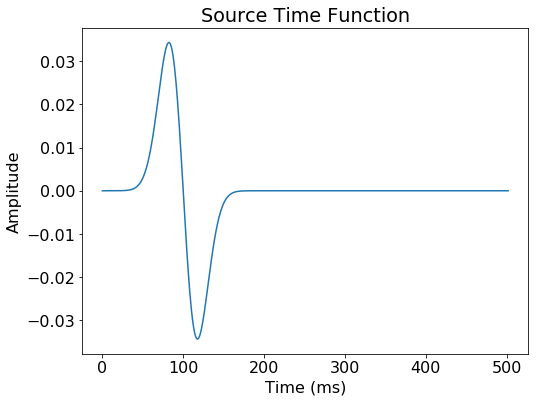

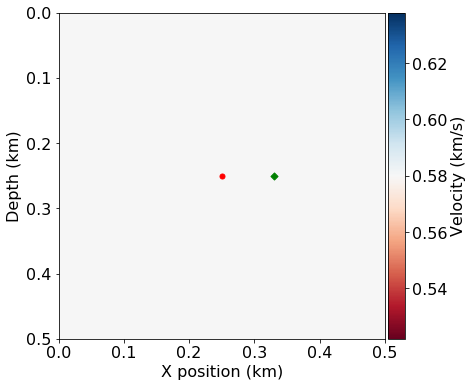

In [6]:
class GaussianSource(WaveletSource):

    def wavelet(self, f0, t):
        # TODO: No idea why this doesn't work
        t0   = 4. / f0 # source time shift
        src  = -2. * (t - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (t - t0) ** 2))
        
f0 = 0.040  # Source peak frequency in kHz
src = GaussianSource(name='src', grid=model.grid, f0=f0, time=1000.*time)
# Manually overwrite with prescreibed values until we figure the above out
src.data[:, 0] = _source / 1000.

# Position source and receiver
src.coordinates.data[0, :] = [250., 250.]
src.show()

rec = Receiver(name='rec', grid=model.grid, npoint=1, ntime=nt)
rec.coordinates.data[0, :] = [330., 250.]

plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data)

CustomCompiler: compiled /tmp/devito-e_f1vr3g/ade02e12877ac68dfd37dcb2733b69a42e6e2918.c [0.33 s]
Section section_1<501,1> with OI=0.94 computed in 0.000 s [0.18 GFlops/s]
Section section_2<501,1> with OI=1.54 computed in 0.000 s [0.15 GFlops/s]
Section main<501,500,500> with OI=1.68 computed in 0.514 s [6.58 GFlops/s, 0.24 GPts/s]


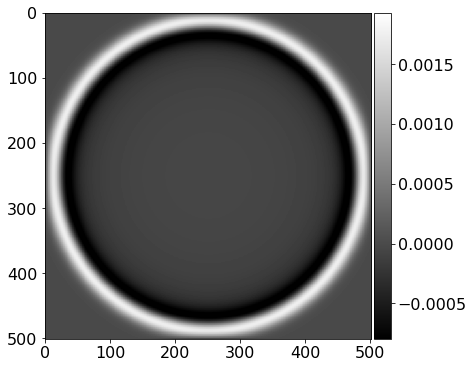

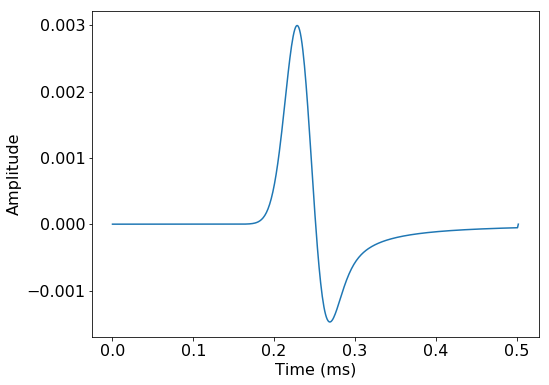

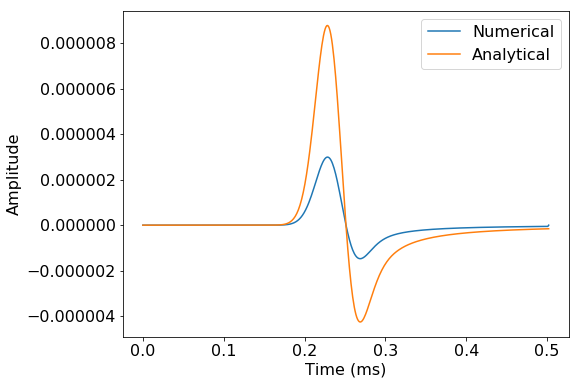

In [7]:
from examples.seismic.acoustic import AcousticWaveSolver
from sympy import solve

solver = AcousticWaveSolver(model, src, rec, space_order=2)
#data , u0, _ = solver.forward(src=src, m=model.m)

u = TimeFunction(name='u', grid=model.grid, space_order=2, time_order=2)
data = Receiver(name='data', grid=model.grid, npoint=1, ntime=nt)
data.coordinates.data[0, :] = [330., 250.]

# Tweak the units to our convention (km/s)
model.vp = np.zeros((nx+1, nz+1), dtype=np.float32) + 0.580
src.data[:, 0] = _source / 1000.

op = solver.op_fwd(False)
args = {'u': u, 'rec': data, 'src': src, 'time': nt, 'dt': dt*1000.}# model.critical_dt}
#print(op.ccode)
#print(op.arguments(**args)['src_coords'])
op(**args)

#print(dt)
#print(model.critical_dt)
plot_image(u.data[0])
plot_seismogram(data.data[:, 0], time=time)
seis_data = {'Numerical': data.data[:, 0] / 1000., 'Analytical': Gc}
plot_seismogram(seis_data, time=time)

CustomCompiler: compiled /tmp/devito-e_f1vr3g/8620d45072148b6fa951ffea1584e6ffe75004ef.c [0.30 s]
Section section_1<502,1> with OI=2.89 computed in 0.000 s [0.32 GFlops/s]
Section section_2<502,1> with OI=4.62 computed in 0.000 s [0.32 GFlops/s]
Section main<502,500,500> with OI=1.41 computed in 0.435 s [4.91 GFlops/s, 0.29 GPts/s]


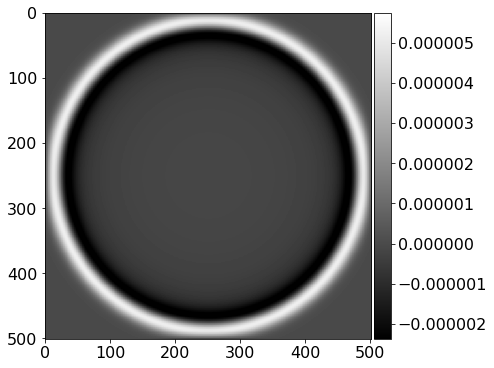

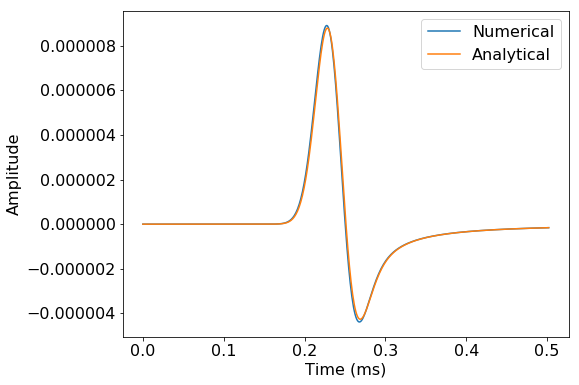

In [8]:
# Set velocity in m/s
model.vp = np.zeros((nx+1, nz+1), dtype=np.float32) + 580.

p = TimeFunction(name='p', grid=model.grid, space_order=2, time_order=2)
p.data[:] = 0.
c = Function(name='c', grid=model.grid)
c.data[:] = c0

r = Receiver(name='r', grid=model.grid, npoint=1, ntime=nt)
r.coordinates.data[0, :] = [330., 250.]

s = PointSource(name='s', grid=model.grid, npoint=1, ntime=nt)
s.data[:, 0] = _source
s.coordinates.data[0, :] = [250., 250.]

# Construct FD operator using Devito (according to Igel et al.)
t = model.grid.stepping_dim
_time = model.grid.time_dim
m = model.m
#eqn = Eq(p.dt2, c**2*(p.dx2 + p.dy2))
eqn = Eq(m * p.dt2 - p.laplace)
wave = [Eq(p.forward, solve(eqn, p.forward)[0])]
#source = Eq(p.indexed[t+1, isx, isz], p.indexed[t+1, isx, isz] + s.indexed[_time, 0] / (dx * dz) * (dt ** 2))
source = s.inject(field=p.forward, expr=s / (dx*dz) * (dt**2))
#receiver = [Eq(r.indexed[_time, 0], p.indexed[t+1, irx, irz])]
receiver = r.interpolate(p.forward)

op = Operator(wave + source + receiver, dse=None, dle=None)
args = {'time':nt+1, 'dt': dt}
#print(op.ccode)

# Trying to use the pre-done wrappers...
#solver = AcousticWaveSolver(model, src, rec, space_order=2)
#op = solver.op_fwd(False)
#args = {'time': nt, 'dt': dt, 'u': p, 'src': s, 'rec': r}

#print(op.arguments(**args)['s'])
op(**args)

plot_image(p.data[0])
seis_data = {'Numerical': r.data[:, 0], 'Analytical': Gc}
plot_seismogram(seis_data, time=time)

In [9]:
# Crude L2 error norm
analytic = Gc
compute = r.data[:, 0]
errorl2 = np.linalg.norm(analytic - compute)
errorl2

2.6838487864777484e-06

# Convergence analysis

Ok, let's use the second, unwrapped, version for now to do some simple experimentation. First, let's see how the interpolation affects things by moving source and receiver to unaligned grid points.

In [10]:
def discretize_time(t0=0., tn=0.5, dt=0.001):
    nt = int((tn-t0) / dt) + 2
    return np.linspace(t0, nt*dt, nt)

def timestep_size(dx, eps=0.58, c0=580.):
    """
    Define timestep size for given epsilon
    """
    # eps = c0 * dt / dx # epsilon value
    return eps * dx / c0

def source_function(time):
    """
    Source time function (Gaussian)
    """
    f0   = 40. # dominant frequency of the source (Hz)
    t0   = 4. / f0 # source time shift
    # 1st derivative of a Gaussian
    return -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

def analytical_solution(src_loc, rec_loc, src, time, c0=580.):
    """
    Analytical Solution
    
    :param src_loc: Source location (tuple)
    :param rec: Receiver location (tuple)
    :param src: Source signature
    :param time: Discretized time values
    """
    nt = len(time) 
    G = time * 0.
    r = np.sqrt((src_loc[0] - rec_loc[0])**2 + (src_loc[1] - rec_loc[1])**2)

    for it in range(nt): # Calculate Green's function
        if ((time[it] - np.abs(rec_loc[0] - src_loc[0]) / c0) >= 0):
            G[it] = (1. / (2 * np.pi * c0 ** 2)) \
            * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
    Gc = np.convolve(G, src * dt)
    return Gc[0:nt]
    

@silencio()
def numerical_solution(ncells=500, src_loc=(250., 250.), rec_loc=(330., 250.),
                       source=_source, order=2, dt=0.001, nt=502, plot=False):
    """
    Wrapper for a single wave propagation with parameters
    """
    extent = (500., 500.)
    shape = (ncells+1, ncells+1)
    grid = Grid(shape=shape, extent=extent)
    #spacing = (extent[0]/ncells, extent[1]/ncells)
    #vp = np.zeros((ncells+1, ncells+1), dtype=np.float32) + 580.
    #model = Model(origin=(0., 0.), spacing=spacing, shape=shape, vp=vp, nbpml=0)

    p = TimeFunction(name='p', grid=grid, space_order=order, time_order=2)
    c = Function(name='c', grid=grid)
    c.data[:] = c0

    nt = len(source)
    s = PointSource(name='s', grid=grid, npoint=1, ntime=nt)
    s.data[:, 0] = source
    s.coordinates.data[0, :] = src_loc
    r = Receiver(name='r', grid=grid, npoint=1, ntime=nt)
    r.coordinates.data[0, :] = rec_loc

    # Construct FD operator using Devito (according to Igel et al.)
    t = model.grid.stepping_dim
    _time = model.grid.time_dim
    m = model.m
    eqn = Eq(p.dt2, c**2*(p.dx2 + p.dy2))
    wave = [Eq(p.forward, solve(eqn, p.forward)[0])]
    #source = Eq(p.indexed[t+1, isx, isz], p.indexed[t+1, isx, isz] + s.indexed[_time, 0] / (dx * dz) * (dt ** 2))
    source = s.inject(field=p.forward, expr=s / (dx*dz) * (dt**2))
    #receiver = [Eq(r.indexed[_time, 0], p.indexed[t+1, irx, irz])]
    receiver = r.interpolate(p.forward)

    op = Operator(wave + source + receiver, dse=None, dle=None)
    args = {'time':nt+1, 'dt': dt}
    op_args = op.arguments(**args)
    print("Operator dt: %s, nt: %s, spacing: (%s, %s)" % (op_args['dt'], op_args['time_e'],
                                                          op_args['h_x'], op_args['h_y']))
    op(**args)
    
    if plot:
        plot_image(p.data[0])
    
    return r.data[:, 0]

Operator dt: 0.0005, nt: 1003, spacing: (0.5, 0.5)


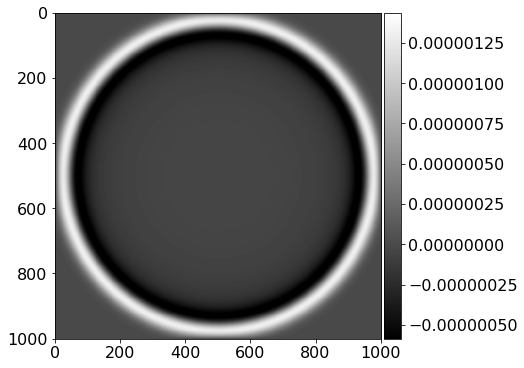

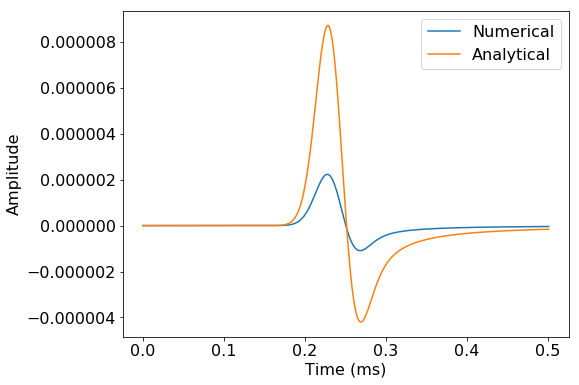

L2 error: 0.0441063269428


In [11]:
# Sanity check that all is still well...
src_loc = (250., 250.)
rec_loc = (330., 250.)

ncells = 1000  # 500
dt = timestep_size(500. / ncells)
time = discretize_time(dt=dt)
source = source_function(time)
source_data = {'Original': _source, 'Source': source}
#plot_seismogram(source_data, time=time)
#print("%s %s" % (_source.shape, source.shape))

analytical = analytical_solution(src_loc, rec_loc, src=source, time=time)
numerical = numerical_solution(ncells=ncells, src_loc=src_loc, rec_loc=rec_loc,
                               source=source, dt=dt, nt=len(time), plot=True)

seis_data = {'Numerical': numerical, 'Analytical': analytical}  #, 'Gc': Gc}
plot_seismogram(seis_data, time=time)

#errorl2 = np.linalg.norm(analytical - numerical)
errorl2 = np.linalg.norm(analytical / np.linalg.norm(analytical) - numerical / np.linalg.norm(numerical))
print("L2 error: %s" % errorl2)

## Effect of interpolation on overall error estimate

In [ ]:
src_loc = (250., 250.)
rec_loc = (330., 250.)
offsets = np.arange(0., 1.1, 0.1)
errorl2 = np.zeros_like(offsets)

# The setup of the problem
ncells = 500
dt = timestep_size(500. / ncells)
time = discretize_time(dt=dt)
source = source_function(time)

for i, o in enumerate(offsets):
    print("Offset %s" % o)
    src_loc_i = (src_loc[0] + o, src_loc[1] + o)
    rec_loc_i = (rec_loc[0] + o, rec_loc[1] + o)
    analytical = analytical_solution(src_loc_i, rec_loc_i, src=source, time=time)
    numerical = numerical_solution(ncells=500, src_loc=src_loc_i, rec_loc=rec_loc_i, source=source)
    
    #errorl2[i] = np.linalg.norm(analytical - numerical)
    errorl2[i] = np.linalg.norm(analytical / np.linalg.norm(analytical) - numerical / np.linalg.norm(numerical))

In [ ]:
plt.figure()
plt.plot(offsets, errorl2)
#plt.loglog(offsets, errorl2)
plt.title('Interpolation error')
plt.xlabel('Intra-cell offset (m)')
plt.tick_params()
plt.ylabel('L2 error')

##  Convergence for fixed order

In [ ]:
src_loc = (250., 250.)
rec_loc = (330., 250.)
#ncells = np.array([16, 32, 64, 128, 256, 500, 512, 768, 1024])
ncells = np.array([125, 250, 500, 750, 1000])
spacing = 500. / ncells
errorl2 = np.zeros(ncells.shape, dtype=np.float32)

for i, nc in enumerate(ncells):
    # The setup of the problem
    dt = timestep_size(500. / nc)
    time = discretize_time(dt=dt)
    source = source_function(time)
    
    analytical = analytical_solution(src_loc, rec_loc, src=source, time=time)
    numerical = numerical_solution(ncells=nc, src_loc=src_loc, rec_loc=rec_loc, source=source, order=2)
    
    #errorl2[i] = np.linalg.norm(analytical - numerical)
    errorl2[i] = np.linalg.norm(analytical / np.linalg.norm(analytical) - numerical / np.linalg.norm(numerical))
    print("No. cells: %s, spacing %s, error: %s" % (nc, spacing[i], errorl2[i]))

In [ ]:
plt.figure()
plt.loglog(spacing, errorl2)
plt.title('Fixed order error')
plt.xlabel('Gird spacing (m)')
plt.tick_params()
plt.ylabel('L2 error')

## Convergence for multiple spatial orders

In [ ]:
src_loc = (250., 250.)
rec_loc = (330., 250.)

order_ncells = {2: [125, 250, 500, 1000],
                4: [125, 250, 500, 1000],
                6: [125, 250, 500, 1000],
                #8: [16, 32, 64],
                }
errorl2 = {}

for order, ncells in order_ncells.items():
    ncells = np.array(ncells)
    spacing = 500. / ncells
    
    errorl2[order] = np.zeros(ncells.shape, dtype=np.float32)
    for i, nc in enumerate(ncells):
        dt = timestep_size(500. / nc)
        time = discretize_time(dt=dt)
        source = source_function(time)
    
        analytical = analytical_solution(src_loc, rec_loc, src=source, time=time)
        numerical = numerical_solution(ncells=nc, src_loc=src_loc, rec_loc=rec_loc, order=order, source=source)
    
        errorl2[order][i] = np.linalg.norm(analytical - numerical)
        print("Order: %s, no. cells: %s, spacing %s, error: %s" % (order, nc, spacing[i], errorl2[order][i])) 

In [ ]:
plt.figure()
for order, error in errorl2.items():
    ncells = np.array(order_ncells[order])
    spacing = 500. / ncells
    
    plt.loglog(spacing, error, label='Order %d' % order)
    
plt.title('')
plt.xlabel('')
plt.tick_params()
plt.legend()
plt.ylabel('L2 error')